In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is dep

In [3]:
proj_name = "ranking_integration_methods"

file_suffix = time.strftime('%b%d-%H%M')

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

# load the pickle files

In [4]:
import pickle as pkl

In [5]:
# cross_tissue_Eraslan
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_updated"
    / "benchmark_cross_tissue_Eraslan_Jul24-1358.pkl"
)

with open(file_path, "rb") as f:
    bm_cross_tissue_Eraslan = pkl.load(f)


In [6]:
# HypoMap_Steuernagel
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_updated"
    / "benchmark_HypoMap_Steuernagel_refined_Jul24-1358.pkl"
)
with open(file_path, "rb") as f:
    bm_HypoMap_Steuernagel = pkl.load(f)

In [7]:
# immune_DominguezConde
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_updated"
    / "benchmark_immune_DominguezConde_Jul24-1358.pkl"
)
with open(file_path, "rb") as f:
    bm_immune_DominguezConde = pkl.load(f)

In [8]:
# pancreatic_islet_Hrovatin
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_updated"
    / "benchmark_pancreatic_islet_Hrovatin_Jul24-1358.pkl"
)
with open(file_path, "rb") as f:
    bm_pancreatic_islet_Hrovatin = pkl.load(f)

In [9]:
# TabulaSapiens
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_updated"
    / "benchmark_TabulaSapiens_Jul24-1358.pkl"
)
with open(file_path, "rb") as f:
    bm_TabulaSapiens = pkl.load(f)

----

# update the combined score

In [40]:
import pandas as pd
import pickle
from pathlib import Path

def update_combined_aggregate_scores(pickle_path: str | Path, output_path: str | Path = None):
    """
    Load a nested benchmark dictionary from a pickle file, update the
    'Aggregate score' fields in the 'combined' DataFrame, and save the result.

    Parameters
    ----------
    pickle_path : str or Path
        Path to the input pickle file.
    output_path : str or Path, optional
        Path to save the updated pickle. If not provided, appends '_updated' to the input filename.
    """
    pickle_path = Path(pickle_path)
    if output_path is None:
        output_path = pickle_path.with_stem(pickle_path.stem + "_updated")
    
    # Load
    with open(pickle_path, "rb") as f:
        bm = pickle.load(f)

    df = bm["combined"]

    # Recompute scores
    df.loc[:, ("Aggregate score", "Batch correction")] = df["Batch correction"].mean(axis=1)
    df.loc[:, ("Aggregate score", "Bio conservation")] = df["Bio conservation"].mean(axis=1)

    # Average the two sub-aggregate scores directly
    total_score = df.loc[:, ("Aggregate score", "Batch correction")].astype(float).add(
        df.loc[:, ("Aggregate score", "Bio conservation")].astype(float)
    ).div(2)

    df.loc[:, ("Aggregate score", "Total")] = total_score

    # Drop the old "Aggregate score", "Average" column
    if ("Aggregate score", "Average") in df.columns:
        df.drop(columns=[("Aggregate score", "Average")], inplace=True) 

    # Save to new file
    with open(output_path, "wb") as f:
        pickle.dump(bm, f)

    print(f"Updated file saved to: {output_path}")


In [51]:
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_old"
    / "benchmark_TabulaSapiens_n=300_Jul23-2142.pkl"
)

output_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_updated"
    / f"benchmark_TabulaSapiens_n=300_{file_suffix}.pkl"
)

In [52]:
update_combined_aggregate_scores(file_path, output_path)

Updated file saved to: /Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24/benchmark_cell_type_summary_updated/benchmark_TabulaSapiens_n=300_Jul24-1358.pkl


----

# plot the ranking results of the integration methods

In [10]:
from benchmark_utils import plot_ranked_scores

In [11]:
bm_cross_tissue_Eraslan["combined"]

Batch correction                                     \
             Graph connectivity     iLISI      KBET PCR comparison   
scvi                   0.877559  0.023635  0.388263       0.448019   
concord_knn            0.819248  0.031493  0.465666       0.708057   
concord_hcl            0.833946  0.031818  0.487603       0.553236   
scanorama              0.791832   0.01882  0.398996              0   
unintegrated           0.722673  0.015155  0.351505              0   
harmony                0.622444  0.051538  0.501787       0.686608   
contrastive             0.76016  0.020304  0.474118              0   

                              Bio conservation                  \
             Silhouette batch            cLISI Isolated labels   
scvi                 0.914381         0.999777        0.632937   
concord_knn          0.746029         0.999785        0.561614   
concord_hcl          0.827863          0.99943        0.591711   
scanorama            0.906145         0.999935        0.620763   
unintegrated         0.946103         0.999897        0.570762   
harmony              0.883754         0.991094        0.544888   
contrastive          0.691881         0.999977        0.579254   

                                                                             \
             KNN state accuracy Leiden ARI Leiden NMI Linear state accuracy   
scvi                   0.930824   0.716627   0.835843              0.918658   
concord_knn            0.901492   0.627627    0.76866              0.905105   
concord_hcl            0.888083   0.621618    0.75356              0.894378   
scanorama              0.941264   0.574064   0.804237              0.935156   
unintegrated           0.940067   0.605722   0.821357              0.942627   
harmony                0.728803   0.412395    0.59357              0.645946   
contrastive            0.933865   0.411019   0.772556              0.932403   

                               Aggregate score                             
             Silhouette label Batch correction Bio conservation     Total  
scvi                 0.528235         0.530372           0.7947  0.662536  
concord_knn          0.495792         0.554099         0.751439  0.652769  
concord_hcl          0.502826         0.546893         0.750229  0.648561  
scanorama            0.513693         0.423159         0.769873  0.596516  
unintegrated           0.5167         0.407087         0.771019  0.589053  
harmony              0.481109         0.549226         0.628258  0.588742  
contrastive          0.551992         0.389293         0.740152  0.564722

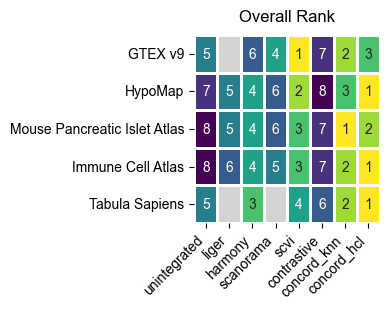

In [ ]:
score_dict = {
    "GTEX v9": bm_cross_tissue_Eraslan["combined"]["Aggregate score"]["Total"],
    "HypoMap": bm_HypoMap_Steuernagel["combined"]["Aggregate score"]["Total"],
    "Mouse Pancreatic Islet Atlas": bm_pancreatic_islet_Hrovatin["combined"]["Aggregate score"]["Total"],
    "Immune Cell Atlas": bm_immune_DominguezConde["combined"]["Aggregate score"]["Total"],
    "Tabula Sapiens": bm_TabulaSapiens["combined"]["Aggregate score"]["Total"]
}

method_order = [
    "unintegrated", "liger", "harmony", "scanorama",
    "scvi", "contrastive", "concord_knn", "concord_hcl"
]

title = "Overall Rank"

plot_ranked_scores(score_dict,
                   figsize = (len(method_order) * 0.5, len(score_dict) * 0.5 + 0.7),
                   custom_rc=custom_rc,
                   method_order=method_order,
                   title=title,
                   save_dir=save_dir,
                   file_name=f"ranked_scores_heatmap_{title}_{file_suffix}",
                    save_format="pdf"
                   )

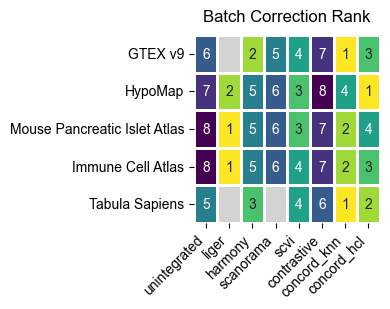

In [16]:
score_dict = {
    "GTEX v9": bm_cross_tissue_Eraslan["combined"]["Aggregate score"]["Batch correction"],
    "HypoMap": bm_HypoMap_Steuernagel["combined"]["Aggregate score"]["Batch correction"],
    "Mouse Pancreatic Islet Atlas": bm_pancreatic_islet_Hrovatin["combined"]["Aggregate score"]["Batch correction"],
    "Immune Cell Atlas": bm_immune_DominguezConde["combined"]["Aggregate score"]["Batch correction"],
    "Tabula Sapiens": bm_TabulaSapiens["combined"]["Aggregate score"]["Batch correction"]
}

method_order = [
    "unintegrated", "liger", "harmony", "scanorama",
    "scvi", "contrastive", "concord_knn", "concord_hcl"
]

title = "Batch Correction Rank"

plot_ranked_scores(score_dict,
                   figsize = (len(method_order) * 0.5, len(score_dict) * 0.5 + 0.7),
                   custom_rc=custom_rc,
                   method_order=method_order,
                   title=title,
                   save_dir=save_dir,
                   file_name=f"ranked_scores_heatmap_{title}_{file_suffix}",
                    save_format="pdf"
                   )

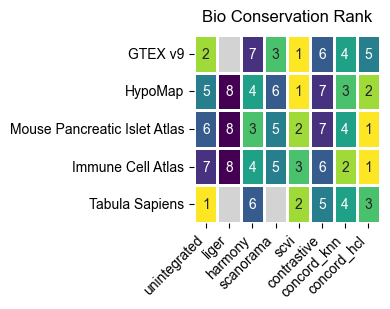

In [17]:
score_dict = {
    "GTEX v9": bm_cross_tissue_Eraslan["combined"]["Aggregate score"]["Bio conservation"],
    "HypoMap": bm_HypoMap_Steuernagel["combined"]["Aggregate score"]["Bio conservation"],
    "Mouse Pancreatic Islet Atlas": bm_pancreatic_islet_Hrovatin["combined"]["Aggregate score"]["Bio conservation"],
    "Immune Cell Atlas": bm_immune_DominguezConde["combined"]["Aggregate score"]["Bio conservation"],
    "Tabula Sapiens": bm_TabulaSapiens["combined"]["Aggregate score"]["Bio conservation"]
}

method_order = [
    "unintegrated", "liger", "harmony", "scanorama",
    "scvi", "contrastive", "concord_knn", "concord_hcl"
]

title = "Bio Conservation Rank"

plot_ranked_scores(score_dict,
                   figsize = (len(method_order) * 0.5, len(score_dict) * 0.5 + 0.7),
                   custom_rc=custom_rc,
                   method_order=method_order,
                   title=title,
                   save_dir=save_dir,
                   file_name=f"ranked_scores_heatmap_{title}_{file_suffix}",
                    save_format="svg"
                   )